<a href="https://colab.research.google.com/github/NatanaelEmilioC/evcomp/blob/master/Scraping_HTML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


<center> <h1><b>Minicurso - Coleta de Dados na Web</b></h1></center>

<h2><b>Web Scraping</b></h2>

<h3>Bernardo Abreu - Vinícius Silva</h3>

Este notebook possui o objetivo de introduzir a estrutura genérica e como funcionam páginas html, bem como a utilização das tags para extrair informações por meio de web scraping.

Também mostraremos um técnica de análise simples aplicada sobre os dados coletados.

## 1- Introdução básica ao HTML
HTML (**H**yper**T**ext **M**arkup **L**anguage) é uma linguagem de marcação utilizada na construção de páginas Web. A linguagem é fortemente baseada no uso de <i>tags</i>, que são estruturas especiais que indicam ao browser, o que cada elemento da página significa e como ele deve ser renderizado.


Estrutura Geral de uma tag HTML:

```html
<nome_da_tag atributo1="val_atributo_1"  atributo2="val_atributo2"> conteudo_da_tag </nome_da_tag>
```
<br/>

### Exemplo:
Criando um link para um site:

```html
<a href="http://www.bigdata.com.br" target="_self"><p>Clique aqui para visitar o site da Big Data</p></a>
```
<ul>
<li>p = marcador que define um parágrafo.</li>
<li>a = marcador que define uma hiperligação (link).</li>
<li>href = atributo que define a url do link.</li>
<li>target = atributo que define a forma como o link será aberto.</li>
<li>_self = valor do atributo Target que define que o link será aberta na mesma guia.</li>
<li>/ = define o fechamento do elemento</li>
</ul>

### Referência para consulta:
Um site extremamente recomendado para quem quer aprender HTML (e desenvolvimento web, no geral) é o W3Schools (https://www.w3schools.com/). Lá você vai encontrar tutoriais interativos de como usar as tags, o que elas fazem, como integrar JavaScript, CSS, Ajax, e muito mais. Vale a pena conferir.

In [0]:
from IPython.display import HTML

first_html = """
  <a href="http://www.bigdata.com.br" target="_self">
    <p>Clique aqui para visitar o site da Big Data</p>
  </a>
"""

HTML(first_html)

## 2- Navegando na hierarquia
 ### Exemplo:

Considere o documento HMTL mostrado abaixo:

```html
<!DOCTYPE html>
<html>
    <head>
        <title>Título do Documento</title>
    </head>
    <body>
      <!-- Aqui fica a página que será visível para todos, onde pode-se inserir
      textos, imagens, links para outras páginas, etc, geralmente usa-se: -->

      <div>Tag para criar-se uma caixa, um bloco, mais utilizada com "Cascading Style Sheets" (CSS) </div>

      <span>Tag para modificação de uma parte do texto da página</span>

      <img src="endereço_de_uma_imagem.jpg" />

      <a href="http://www.wikipedia.org">Wikipedia, A Enciclopédia Livre</a>
    </body>
</html>
```

Neste exemplo, podemos ver um recurso extremamente útil na linguagem HTML, que é o aninhamento de tags. Perceba que a tag **title** está aninhada dentro da tag **head**, que por sua vez, está aninhada dentro da tag **html**. Dizemos que a tag **title** é filha (*child*) da tag **head** (dita tag pai ou *parent*), que por sua vez é filha da tag **html**. Ambas as tags **title** e **head** são ditas descendentes da tag **html**. Tags no mesmo nível de aninhamento, (como **div** e **span**, neste exemplo) são chamadas tags irmãs. Esse aninhamento cria uma espécie de hierarquia dentro de um documento HTML que nos será muito útil do ponto de vista do web scraping.

O formato estruturado de um arquivo HTML nos permite utilizar ferramentas de querying no documento. Através dessas ferramentas, podemos fazer consultas ao documento e fazer perguntas como: Qual o conteúdo da tag span? Ou ainda, qual o valor do atributo src da tag image?

<br/>

### A Linguagem XPath:

A tecnologia XPath (XML Path Language) é uma linguagem de consulta utilizada para selecionar nós de um documento XML. Além disso, também pode ser usada para computar valores (strings, números, booleanos, etc) do conteúdo de um documento XML.

### Exemplo:

Copie o código HTML mostrado acima e cole-o no campo XML Input do site https://www.freeformatter.com/xpath-tester.html

No campo XPath expression, colocaremos as expressões XPath propriamente ditas para respondermos algumas perguntas de nosso interesse a respeito do documento

1- Qual o conteúdo da tag span? <br/>
R: //span/text()

2- Qual o valor do atributo src da tag image? <br/>
R: //img/@src

<br/>

### Referência para consulta:

Um recurso bastante interessante para se ter em mãos ao fazer web scraping, é a cheat sheet do XPath, disponível aqui: https://devhints.io/xpath

Com ela, podemos ter acesso fácil às principais funcionalidades da linguagem, sendo um meio rápido de resolver problemas básicos. Para problemas mais complexos e discussões de melhores práticas, é bom recorrer ao bom e velho StackOverflow.


## 3- Praticando

Mesmo que o que mostramos até agora pareça bastante básico, vamos mostrar que já é o suficiente para crawlearmos um site simples.
Um site básico que podemos utilizar é o quotes.toscrape.com, que foi criado justamente para ensinar novatos a coletar dados na web. Trata-se de uma página com relativamente poucos elementos e que não implementa mecanismos de bloqueio. É um bom lugar para começar.

O site contém citações de autores renomados, tageadas e dispostas ao longo de 10 páginas. Nosso objetivo com esse tutorial é coletar todas as citações e seus respectivos autores e tags.
Uma vez que tivermos os dados, criaremos uma wordcloud com as top 15 tags mais usadas.

Vamos começar instalando algumas bibliotecas que nos auxiliarão a completar essa tarefa. 

A biblioteca scrapy é extremamente útil para a criação de crawlers. Ela fornece ferramentas para a paralelização de requests, uma plataforma para a execução de consultas XPath, meios para integração com proxies, etc. Para esse tutorial em específico, estamos interessados na sua capacidade de execução de queries XPath.

Já a biblioteca wordcloud, como o próprio nome diz, é utilizada para fazer desenhos gráficos de uma wordcloud.

In [0]:
# Instalando bibliotecas
!pip install scrapy
!pip install wordcloud

In [0]:
import requests
from scrapy.http import TextResponse

In [0]:
def send_request_to_url(site_url):
    # py_res --> Response nativa do Python
    py_res = requests.get(site_url)
    # print(py_res)

    # scrapy_res --> Response própria para ser utilizada no scrapy
    scrapy_res = TextResponse(py_res.url, body=py_res.text, encoding='utf-8')

    return scrapy_res

In [0]:
import time

# Navega pelo website coletando as citações de cada autor


def scrape_website():

    page_str = ''
    quotations = []

    # iteramos sobre as paginas até que não exista mais o botao próximo
    while(True):

        # observacao: estamos fazendo requests em um loop. Adicionaremos um delay
        scrapy_res = send_request_to_url(
            'http://quotes.toscrape.com/' + page_str)
        # Delay de 1s
        time.sleep(1)

        # Nosso primeiro uso de XPath: recebemos uma list de Selectors em que cada
        # elemento "aponta" para um resultado da query.
        # Cada resultado corresponde a uma tag div cuja "classe" é 'quote'
        for sel in scrapy_res.xpath('//div[@class="quote"]'):

            # Dentro do loop, fazemos o parsing das tags filhas do div corrente
            quotation_dict = {}

            # Le a citação em si (Tag span, classe "text")
            quotation_dict['quote'] = (sel
                                       .xpath('.//span[@class="text"]/text()')
                                       .extract_first())
            # Le o autor da citação
            quotation_dict['author'] = (sel
                                        .xpath('.//small[@class="author"]/text()')
                                        .extract_first())

            # Le a lista de tags da citação
            quotation_dict['tags'] = ('; '.join(sel
                                                .xpath('.//a[@class="tag"]/text()')
                                                .extract()))

            quotations.append(quotation_dict)

            # Lê o link que está no botão 'Próximo'
            page_str = scrapy_res.xpath(
                '//li[@class="next"]/a/@href').extract_first()

        # Se o botao 'Próximo' não existir, significa que estamos na ultima página
        # Nesse caso, não precisamos mais fazer requests. Interrompemos o loop
        if not page_str:
            return quotations

In [0]:
import pandas as pd

# Salva as quotations em um arquivo csv atraves do pandas dataframe
def save_quotations_to_csv(quotations):

    quotations_df = pd.DataFrame(quotations)

    # Exibimos o head do dataframe
    display(quotations_df.head())

    quotations_df.to_csv('quotations.csv', index=False)

In [0]:
# Recebe a lista de dicts e retorna uma lista contendo todas as tags
def generate_tags_list(quotations):

    # gera uma lista das tags
    tags_list = []
    for q in quotations:
        q_tags = q['tags'].split(';')
        q_tags = map(lambda x: x.strip(), q_tags)
        tags_list.extend(q_tags)

    # Remove ocorrencias de tags vazias
    tags_list = filter(lambda x: x!='', tags_list)

    return tags_list

In [0]:
"""
  Função que recebe a lista de dicts com as quotations e retorna um dict 
  contendo a contagem das ocorrencias das top n tags.
"""
def get_top_n_tags(tags_list, n):

    # Gera um dicionario com as contagens das tags
    occur_dict = dict((x,tags_list.count(x)) for x in set(tags_list))

    # Filtra as top n tags mais usadas
    occur_dict = {
        k: v for k, v in sorted(
            occur_dict.items(),
            key=lambda item: item[1],
            reverse=True
        )[:n]
    }

    return occur_dict

In [0]:
# biblioteca usada para criar a wordcloud
from wordcloud import WordCloud

# biblioteca usada para exibir a wordcloud
import matplotlib.pyplot as plt


def generate_word_cloud(top_tags, tags_list):

    # Filtra tags_list para que tenha somente as palavras presentes em occur_dict
    text = ' '.join(list(filter(lambda x: x in top_tags, tags_list)))

    # Gera e exibe a wordcloud propriamente dita
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [0]:
def run_script():

    quotations = scrape_website()
    save_quotations_to_csv(quotations)
    tags_list = list(generate_tags_list(quotations))

    top_15_tags = get_top_n_tags(tags_list, 15)

    generate_word_cloud(top_15_tags, tags_list)


,quote,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,change; deep-thoughts; thinking; world
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,abilities; choices
2,“There are only two ways to live your life. On...,Albert Einstein,inspirational; life; live; miracle; miracles
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,aliteracy; books; classic; humor
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,be-yourself; inspirational


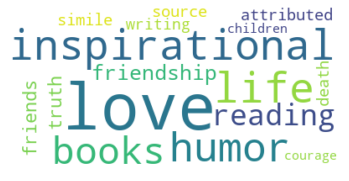

In [0]:
run_script()

# Usando Scrapy

Scrapy é uma ferramenta muito versátil para fazer crawlers, apresentando algumas vantagens em relação à pura utilização de requests.

Apesar disso, a primeira vista pode parecer mais complicado criar um crawler utilizando scrapy quando não se tem experiência com o mesmo.

Abaixo vamos mostrar um crawler feito com scrapy que realiza a mesma coleta feita acima com requests.

In [0]:
import scrapy
import logging
from scrapy.crawler import CrawlerProcess

In [0]:
import json

class JsonWriterPipeline(object):

    def open_spider(self, spider):
        self.file = open('quoteresult.jl', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

In [0]:
class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = [
        'http://quotes.toscrape.com',
    ]
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, # Used for pipeline 1
        'FEED_FORMAT':'json',                                 # Used for pipeline 2
        'FEED_URI': 'quoteresult.json'                        # Used for pipeline 2
    }

    def parse(self, response):
        print(response)
        for sel in response.xpath('//div[@class="quote"]'):      
            # Dentro do loop, fazemos o parsing das tags filhas do div corrente
            quotation_dict = {}

            # Le a citação em si (Tag span, classe "text")
            quotation_dict['quote'] = (sel
                                    .xpath('.//span[@class="text"]/text()')
                                    .extract_first())
            # Le o autor da citação
            quotation_dict['author'] = (sel
                                        .xpath('.//small[@class="author"]/text()')
                                        .extract_first())

            # Le a lista de tags da citação
            quotation_dict['tags'] = ('; '.join(sel
                                                .xpath('.//a[@class="tag"]/text()')
                                                .extract()))
            yield quotation_dict

        # Lê o link que está no botão 'Próximo'
        page_str = response.xpath('//li[@class="next"]/a/@href').extract_first()

        # Se o botao 'Próximo' não existir, significa que estamos na ultima página
        # Nesse caso, não precisamos mais fazer requests. Interrompemos o loop
        if page_str is not None:
            next_page = response.urljoin(page_str)
            yield scrapy.Request(next_page, callback=self.parse)

In [0]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(QuotesSpider)
process.start()

2020-02-19 05:04:27 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-02-19 05:04:27 [scrapy.utils.log] INFO: Versions: lxml 4.2.6.0, libxml2 2.9.8, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.6.9 (default, Nov  7 2019, 10:44:02) - [GCC 8.3.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
2020-02-19 05:04:27 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'quoteresult.json', 'LOG_LEVEL': 30, 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


<200 http://quotes.toscrape.com>
<200 http://quotes.toscrape.com/page/2/>
<200 http://quotes.toscrape.com/page/3/>
<200 http://quotes.toscrape.com/page/4/>
<200 http://quotes.toscrape.com/page/5/>
<200 http://quotes.toscrape.com/page/6/>
<200 http://quotes.toscrape.com/page/7/>
<200 http://quotes.toscrape.com/page/8/>
<200 http://quotes.toscrape.com/page/9/>
<200 http://quotes.toscrape.com/page/10/>


In [0]:
quoteresult_scrapy = []
with open('quoteresult.jl', 'r') as f:
    for line in f:
        quoteresult_scrapy.append(json.loads(line))

In [0]:
len(quoteresult_scrapy)

100

In [0]:
quoteresult_scrapy[:10]

[{'author': 'Albert Einstein',
  'quote': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
  'tags': 'change; deep-thoughts; thinking; world'},
 {'author': 'J.K. Rowling',
  'quote': '“It is our choices, Harry, that show what we truly are, far more than our abilities.”',
  'tags': 'abilities; choices'},
 {'author': 'Albert Einstein',
  'quote': '“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”',
  'tags': 'inspirational; life; live; miracle; miracles'},
 {'author': 'Jane Austen',
  'quote': '“The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.”',
  'tags': 'aliteracy; books; classic; humor'},
 {'author': 'Marilyn Monroe',
  'quote': "“Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.”",
  'tags': 'be-yourself; inspirational'},

## Crawleando sites mais complexos

### Skyscanner

O site www.skyscanner.com é uma excelente ferramenta para acompanhar informações de voos em tempo real. Esses dados podem ser bastante valiosos e não faltam razões para querer obtê-los. 
Neste exemplo, iremos mostrar uma técnica ligeiramente diferente de web scraping.

Ao invés de fazermos consultas ao HTML da página usando XPath, vamos clonar as requests feitas pelo browser de forma a obter apenas aquilo que nos interessa.

In [0]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Uma ferramenta muito útil para encontrar a request exata feita por um site para obter os dados a serem exibidos é o *browser console*.

Por exemplo, suponham que queiramos obter os dados de chegada e partida de um certo aeroporto, como o aeroporto de Congonhas.

Após pesquisar no site Skyscanner, ou mesmo fazendo uma busca na internet, chegamos à seguinte URL:

In [0]:
url = 'https://www.skyscanner.com.br/passagens-aereas/chegadas-partidas/cgh/sao-paulo---congonhas-chegadas-partidas'

Essa URL contém todas as chegadas e partidas do aeroporto de Congonhas no dia de hoje. Utilizando a técnica vista anteriormente, seria possível fazer o scraping dessa página para obter todas as informações dispostas através dos elementos dispostos na própria página.

Mas será que existe um jeito melhor?

Ao abrir o *browser console* e abrir a aba *network* é possível ver as requisições feitas pelo site. (Caso a página esteja em branco, basta recarregá-la para que as requisições sejam refeitas)

É possível ainda filtrar essas requisições pelo filtro XHR, que, segundo a Wikipédia, é uma API na forma de um objeto, cujos métodos transferem dados entre um *browser* e um servidor.

Dados são exatamente o nosso objetivo ao fazer scraping do site. Portanto podemos tentar verificar se alguns desses dados estão sendo requisitados diretamente nessa aba, de forma que a repetir a requisição e obter os dados sem precisar fazer o scraping.

Como o número de requisições listadas é muito alta, uma boa dica é pesquisar algum elemento conhecido do dado que você está buscando na aba de pesquisa.

Ao encontrar a requisição que pede um arquivo JSON com os dados desejados, podemos estrair a requisição em cURL e convertê-la para outra linguagem caso necessário.

Um bom site para isso é o https://curl.trillworks.com/#python.

A requisição obtida foi essa abaixo.

In [0]:
import requests

headers = {
    'authority': 'gateway.skyscanner.net',
    'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Mobile Safari/537.36',
    'accept': '*/*',
    'origin': 'https://www.skyscanner.com.br',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'referer': 'https://www.skyscanner.com.br/passagens-aereas/chegadas-partidas/gru/internacional-de-sao-paulo-guarulhos-chegadas-partidas',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9,pt-BR;q=0.8,pt;q=0.7,es-ES;q=0.6,es;q=0.5',
}

params = (
    ('locale', 'pt-BR'),
)

response = requests.get('https://gateway.skyscanner.net/arrival-departure-svc/api/airports/GRU/statuses', headers=headers, params=params)

Muitos dos elementos são geralmente desnecessários. Existem sites mais complicados que exigem que você guarde os cookies, user-agent, ou outra informação qualquer para acessá-los, mas esse náo é um deles. Portanto podemos simplificas a requisição.

In [0]:
response = requests.get('https://gateway.skyscanner.net/arrival-departure-svc/api/airports/GRU/statuses')

Foram obtidos os dados em estruturados em JSON, que elimina a maior parte do trabalho feito em scraping.

In [0]:
json.loads(response.text).keys()

dict_keys(['airportInfo', 'arrivals', 'departures'])

Agora suponha que você deseje obter esses mesmos dados, mas para todos os aeroportos do Brasil. Ao observar a URL da requisição, é possível notar que o código do aeroporto faz parte da mesma. Assim, é de se esperar que ao colocar diferentes códigos de aeroportos, obtenha-se as informações para os respectivos aeroportos.

In [0]:
url = 'https://gateway.skyscanner.net/arrival-departure-svc/api/airports/'

In [0]:
# Aqui se encontra uma lista com todos os aeroportos do Brasil.
# Fazer as requisições para todos eles pode demorar um bom tempo, caso não
# deseje ficar esperando muito tempo, use a célula de baixo para pesquisar menos aeroportos.

# airports = ['AJU', 'AQA', 'ARU', 'ATM', 'AUX', 'BAU', 'BEL', 'BPS', 'BRA',
#             'BSB', 'BVB', 'BZC', 'CAF', 'CAW', 'CFB', 'CFO', 'CGB', 'CGH',
#             'CGR', 'CIZ', 'CKS', 'CLV', 'CMG', 'CNF', 'CPV', 'CWB', 'CXJ',
#             'CZS', 'DIQ', 'ERM', 'ERN', 'FEN', 'FLN', 'FOR', 'GEL', 'GIG',
#             'GRU', 'GVR', 'GYN', 'IGU', 'IMP', 'IOS', 'IPN', 'ITB', 'IZA',
#             'JDF', 'JDO', 'JJD', 'JJG', 'JOI', 'JPA', 'JTC', 'LBR', 'LDB',
#             'MAB', 'MAO', 'MCP', 'MCZ', 'MEA', 'MGF', 'MII', 'MOC', 'NAT',
#             'NVT', 'PET', 'PFB', 'PIN', 'PLU', 'PMW', 'PNZ', 'POA', 'PPB',
#             'PVH', 'RAO', 'RBR', 'REC', 'RIA', 'RIG', 'ROO', 'SDU', 'SJK',
#             'SJL', 'SJP', 'SLZ', 'SSA', 'STM', 'TFF', 'THE', 'TJL', 'TMT',
#             'UDI', 'VAG', 'VCP', 'VDC', 'VIX', 'XAP']

In [0]:
# Um subconjunto dos aeroportos do Brasil.
airports = ['AJU', 'AQA', 'ARU', 'ATM', 'AUX', 'BAU', 'BEL', 'BPS', 'BRA',
           'BSB', 'BVB', 'BZC', 'CAF', 'CAW', 'CFB', 'CFO', 'CGB', 'CGH',
           'CGR', 'CIZ', 'CKS', 'CLV', 'CMG', 'CNF', 'CPV', 'CWB', 'CXJ',
           'CZS', 'DIQ', 'ERM', 'ERN', 'FEN', 'FLN', 'FOR', 'GEL', 'GIG',
           'GRU', 'GVR', 'GYN', 'IGU', 'IMP', 'IOS', 'IPN', 'ITB', 'IZA']

Abaixo nós fazemos uma requisição para cada aeroporto e guardamos todas as informações em uma lista.

In [0]:
all_airports = []
for airport in airports:
    response = requests.get(f'{url}{airport}/statuses')
    airport_data = json.loads(response.text)
    all_airports.append(airport_data)

Também é possível que você queira guardar os dados exatamente como eles vieram, sem fazer nenhum processamento a mais.

In [0]:
with open('airport_data.json', 'w') as f:
    json.dump(all_airports, f)

In [0]:
with open('airport_data.json', 'r') as f:
    all_airports = json.load(f)

In [0]:
def format_airport_data(airport_data):
    airport_info = {}

    airport_info['airport_id'] = airport_data['airportInfo']['iataCode']
    airport_info['name'] = airport_data['airportInfo']['name']
    airlines = set()
    for arrival in airport_data['arrivals']:
        airlines.add(arrival['airlineId'])

    for departure in airport_data['departures']:
        airlines.add(departure['airlineId'])
    airport_info['num_of_airlines'] = len(airlines)
    airport_info['airlines'] = list(airlines)

    airport_info['num_of_arrivals'] = len(airport_data['arrivals'])
    airport_info['num_of_departures'] = len(airport_data['departures'])
    return airport_info

In [0]:
all_airports_info = []
for airport in all_airports:
    all_airports_info.append(format_airport_data(airport))

In [0]:
df_airports = pd.DataFrame(all_airports_info)

In [0]:
df_airports.head()

,airport_id,name,num_of_airlines,airlines,num_of_arrivals,num_of_departures
0,AJU,Aracaju,3,"[AD, G3, LA]",15,13
1,AQA,Araraquara,1,[AD],1,1
2,ARU,Aracatuba,3,"[AD, 84, G3]",5,5
3,ATM,Altamira,2,"[AD, JR]",3,3
4,AUX,Araguaina,1,[84],1,1


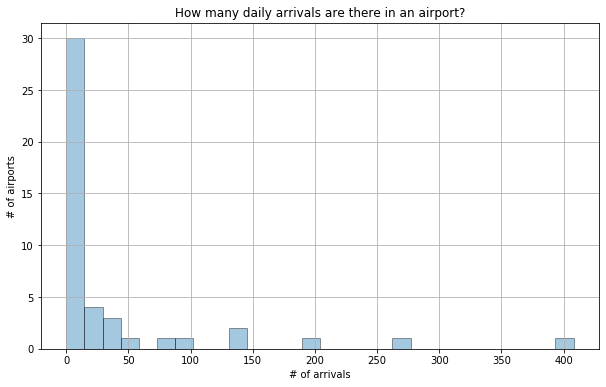

In [0]:
plt.figure(figsize=(10, 6))
sns.distplot(df_airports['num_of_arrivals'], kde=False, hist_kws={'edgecolor':'black'})

plt.title('How many daily arrivals are there in an airport?')
plt.ylabel('# of airports')
plt.xlabel('# of arrivals')
plt.grid(True)
plt.show()

In [0]:
df_airports.sort_values(by='num_of_arrivals', ascending=False).head(10)

,airport_id,name,num_of_airlines,airlines,num_of_arrivals,num_of_departures
36,GRU,Sao Paulo Guarulhos,31,"[H2, ~F, G3, IB, TP, AT, AA, KL, EK, ET, AM, L...",408,404
17,CGH,Sao Paulo Congonhas,4,"[AD, 84, G3, LA]",268,270
9,BSB,Brasilia,8,"[, TP, AA, AD, 84, G3, LA, CM]",193,186
23,CNF,Belo Horizonte Tancredo Neves Int'l.,6,"[, TP, AD, G3, LA, CM]",145,143
35,GIG,Rio De Janeiro Internacional,24,"[, H2, ~F, 77, G3, IB, TP, AA, KL, EK, LA, UA,...",133,132
25,CWB,Curitiba,5,"[AD, CV, G3, LA, AR]",93,93
33,FOR,Fortaleza,6,"[TP, AF, AD, 84, G3, LA]",76,66
32,FLN,Florianopolis,5,"[H2, AD, G3, LA, AR]",48,47
6,BEL,Belem,5,"[AD, G3, LA, UA, JR]",43,41
16,CGB,Cuiaba,4,"[, AD, G3, LA]",42,41


In [0]:
def format_flight(airport):
    all_formatted_data = []
    for data in airport:
        formatted_data = {}
        formatted_data['airlineId'] = data['airlineId']
        formatted_data['airlineName'] = data['airlineName']
        formatted_data['flightNumber'] = data['flightNumber']
        formatted_data['arrivalAirportCode'] = data['arrivalAirportCode']
        formatted_data['departureAirportCode'] = data['departureAirportCode']

        formatted_data['localisedScheduledDepartureTime'] = data['localisedScheduledDepartureTime']
        formatted_data['localisedScheduledArrivalTime'] = data['localisedScheduledArrivalTime']

        formatted_data['localisedEstimatedDepartureTime'] = data['localisedEstimatedDepartureTime']
        formatted_data['localisedEstimatedArrivalTime'] = data['localisedEstimatedArrivalTime']

        all_formatted_data.append(formatted_data)
    return all_formatted_data

In [0]:
arrival_data = []

for airport in all_airports:
    arrival_data.extend(format_flight(airport['arrivals']))

In [0]:
df_arrival_data = pd.DataFrame(arrival_data)

In [0]:
df_arrival_data[['localisedScheduledDepartureTime', 'localisedScheduledArrivalTime', 'localisedEstimatedDepartureTime', 'localisedEstimatedArrivalTime']] = df_arrival_data[['localisedScheduledDepartureTime', 'localisedScheduledArrivalTime', 'localisedEstimatedDepartureTime', 'localisedEstimatedArrivalTime']].apply(pd.to_datetime)

In [0]:
df_arrival_data

,airlineId,airlineName,flightNumber,arrivalAirportCode,departureAirportCode,localisedScheduledDepartureTime,localisedScheduledArrivalTime,localisedEstimatedDepartureTime,localisedEstimatedArrivalTime
0,G3,GOL Linhas Aéreas,G31504,AJU,GRU,2020-02-18 21:50:00,2020-02-19 00:30:00,2020-02-18 22:52:00,2020-02-19 01:22:00
1,AD,Azul Airlines,AD2484,AJU,SSA,2020-02-19 00:55:00,2020-02-19 01:45:00,2020-02-19 00:52:00,2020-02-19 01:35:00
2,LA,LATAM Airlines,LA3398,AJU,GRU,2020-02-18 23:45:00,2020-02-19 02:30:00,2020-02-18 23:44:00,2020-02-19 02:29:00
3,AD,Azul Airlines,AD2713,AJU,REC,2020-02-19 09:10:00,2020-02-19 10:35:00,2020-02-19 09:10:00,2020-02-19 10:35:00
4,G3,GOL Linhas Aéreas,G32012,AJU,GIG,2020-02-19 08:30:00,2020-02-19 10:50:00,2020-02-19 08:30:00,2020-02-19 10:50:00
...,...,...,...,...,...,...,...,...,...
1624,JR,MAP Linhas Aéreas,7M5912,ITB,PIN,2020-02-19 08:30:00,2020-02-19 10:00:00,NaT,NaT
1625,JR,MAP Linhas Aéreas,7M5913,ITB,ATM,2020-02-19 16:15:00,2020-02-19 17:20:00,2020-02-19 15:15:00,NaT
1626,AD,Azul Airlines,AD4352,IZA,VCP,2020-02-19 08:30:00,2020-02-19 10:05:00,NaT,NaT
1627,G3,GOL Linhas Aéreas,G31352,IZA,CGH,2020-02-19 11:35:00,2020-02-19 12:45:00,2020-02-19 11:35:00,2020-02-19 12:45:00


In [0]:
df_arrival_data['departure_delay'] = (df_arrival_data['localisedEstimatedDepartureTime'] - df_arrival_data['localisedScheduledDepartureTime']).apply(lambda x: pd.Timedelta(x).total_seconds() / 60)
df_arrival_data['arrival_delay'] = (df_arrival_data['localisedEstimatedArrivalTime'] - df_arrival_data['localisedScheduledArrivalTime']).apply(lambda x: pd.Timedelta(x).total_seconds() / 60)

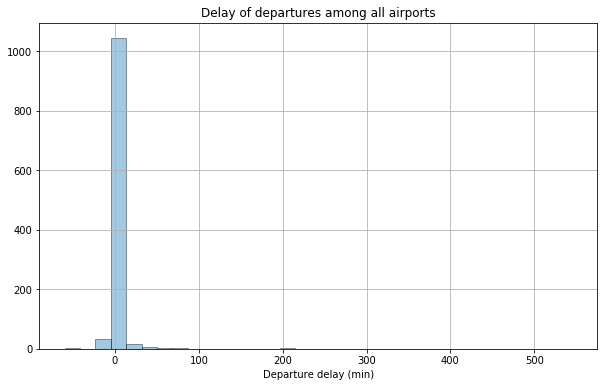

In [0]:
plt.figure(figsize=(10, 6))
ax = sns.distplot(df_arrival_data['departure_delay'].dropna(), kde=False, hist_kws={'edgecolor':'black'})

plt.title('Delay of departures among all airports')
plt.xlabel('# of flights')
plt.xlabel('Departure delay (min)')
plt.grid(True)
plt.show()

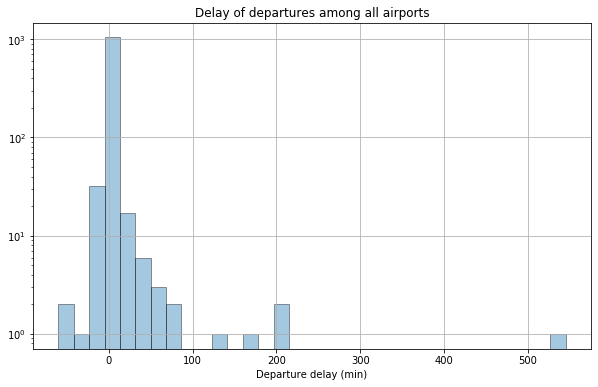

In [0]:
plt.figure(figsize=(10, 6))
ax = sns.distplot(df_arrival_data['departure_delay'].dropna(), kde=False, hist_kws={'edgecolor':'black'})

plt.title('Delay of departures among all airports')
plt.xlabel('# of flights')
plt.xlabel('Departure delay (min)')
ax.set_yscale('log')
plt.grid(True)
plt.show()

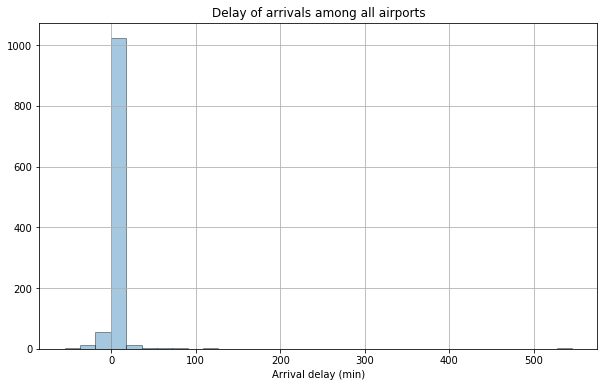

In [0]:
plt.figure(figsize=(10, 6))
ax = sns.distplot(df_arrival_data['arrival_delay'].dropna(), kde=False, hist_kws={'edgecolor':'black'})

plt.title('Delay of arrivals among all airports')
plt.xlabel('# of flights')
plt.xlabel('Arrival delay (min)')
plt.grid(True)
plt.show()

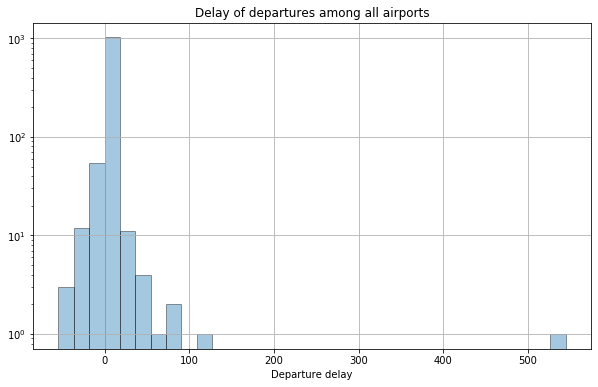

In [0]:
plt.figure(figsize=(10, 6))
ax = sns.distplot(df_arrival_data['arrival_delay'].dropna(), kde=False, hist_kws={'edgecolor':'black'})

plt.title('Delay of departures among all airports')
plt.xlabel('# of flights')
plt.xlabel('Departure delay')

ax.set_yscale('log')
plt.grid(True)
plt.show()